In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min

from torch_geometric.nn import GCNConv

from sklearn import tree, linear_model

import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestCentroid
import umap

from torch_geometric.nn import GNNExplainer

from utilities import *
from heuristics import *
from activation_classifier import *
import random
import models

set_rc_params()

# ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

/home/wash/Work/Cambridge/PartIII/L45/gnn_project/GCExplainer-unsupervised/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-24 11:55:34.555843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# general parameters
dataset_name = "local_100_BA_Shapes"

model_type = BA_Shapes_GCN
load_pretrained = True
use_extern_model = True
external_activations = "../../100_bashapes.embeds.npy"

# hyperparameters
k = 5

# other parameters
train_test_split = 0.8
num_hidden_units = 20
num_classes = 4

epochs = 2500
lr = 0.001

In [3]:
paths = prepare_output_paths(dataset_name, k)

G, labels = load_syn_data(dataset_name)
data = prepare_syn_data(G, labels, train_test_split)

if not use_extern_model:
    model = model_type(data["x"].shape[1], num_hidden_units, num_classes, "BA-Shapes")

    if load_pretrained:
        print("Loading pretrained model...")
        model.load_state_dict(torch.load(os.path.join(paths['base'], "model.pkl")))
        model.eval()
        
        with open(os.path.join(paths['base'], "activations.txt"), 'rb') as file:
            activation_list = pickle.loads(file.read())
            
    else:
        model.apply(weights_init)
        train(model, data, epochs, lr, paths['base'])

Task: Node Classification
Number of features:  500
Number of labels:  500
Number of classes:  500
Number of edges:  2


In [4]:
x = data["x"]
edges = data["edges"]
y = data["y"]
train_mask = data["train_mask"]
test_mask = data["test_mask"]
if not use_extern_model:
    print(test(model, x, y, edges, train_mask))
    print(test(model, x, y, edges, test_mask))

In [5]:
if use_extern_model:
    activation_list = {"embs": torch.Tensor(np.load(external_activations))}
else:
    activation_list.pop("conv0")
    activation_list.pop("conv1")
    activation_list.pop("conv2")
    activation_list.pop("linear")

for layer_num, key in enumerate(activation_list):
    print(key)
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    print(activation.shape)

embs
(500, 16)


# Dimensionality Reduction

### TSNE

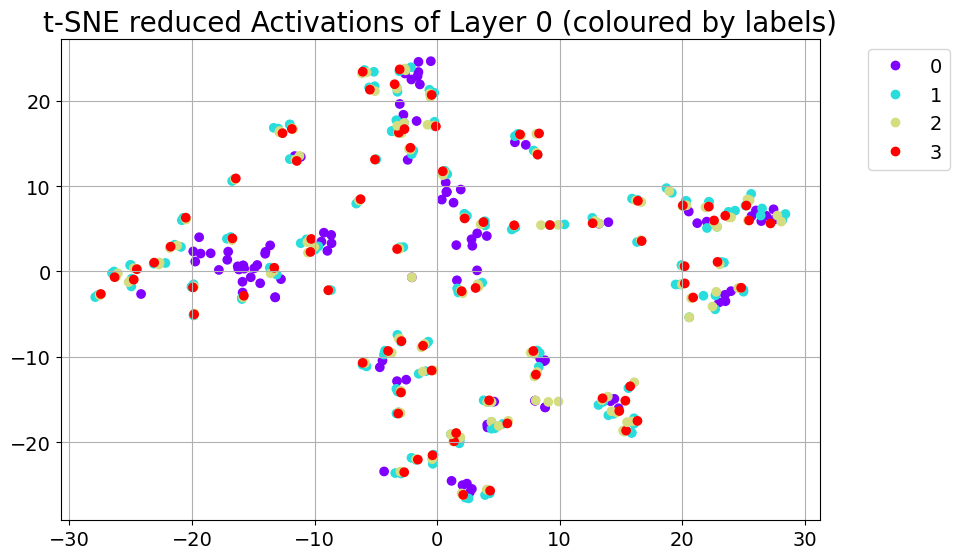

In [6]:
# TSNE conversion
tsne_models = []
tsne_data = []

for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    tsne_model = TSNE(n_components=2)
    d = tsne_model.fit_transform(activation)
    plot_activation_space(d, labels, "t-SNE reduced", layer_num, paths['TSNE'], "(coloured by labels)")
    
    tsne_models.append(tsne_model)
    tsne_data.append(d)

### PCA

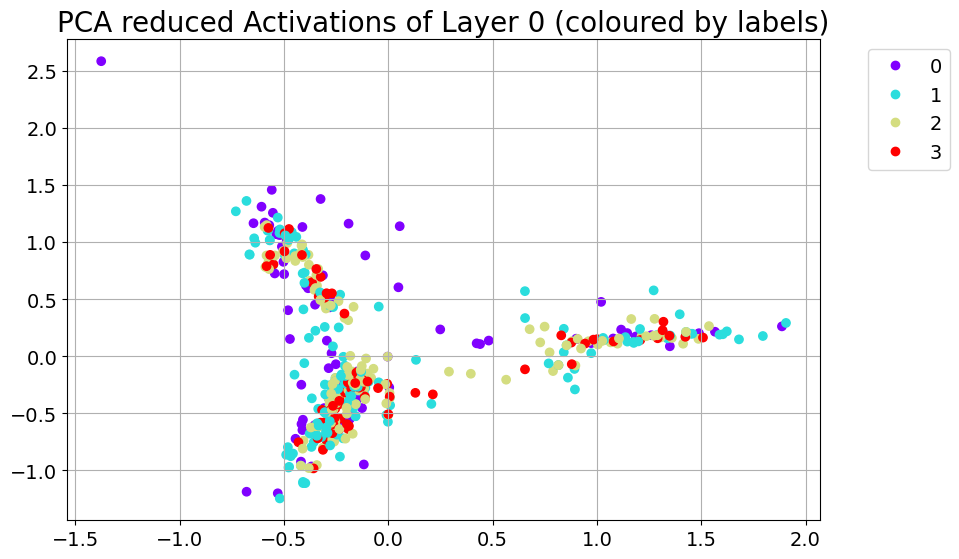

In [7]:
# PCA conversion
pca_models = []
pca_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pca_model = PCA(n_components=2)
    d = pca_model.fit_transform(activation)
    plot_activation_space(d, labels, "PCA reduced", layer_num, paths['PCA'], "(coloured by labels)")

    pca_models.append(pca_model)
    pca_data.append(d)

### UMAP

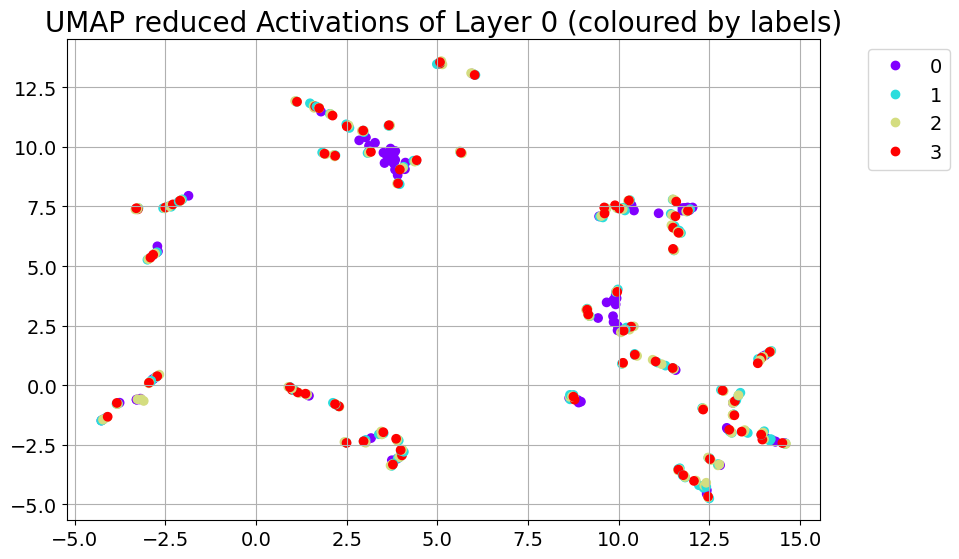

In [8]:
# UMAP conversion
umap_models = []
umap_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    umap_model = umap.UMAP(n_components=2)
    d = umap_model.fit_transform(activation)
    plot_activation_space(d, labels, "UMAP reduced", layer_num, paths['UMAP'], "(coloured by labels)")

    umap_models.append(umap_model)
    umap_data.append(d)

# Clustering

### KMeans

##### RAW

/home/wash/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


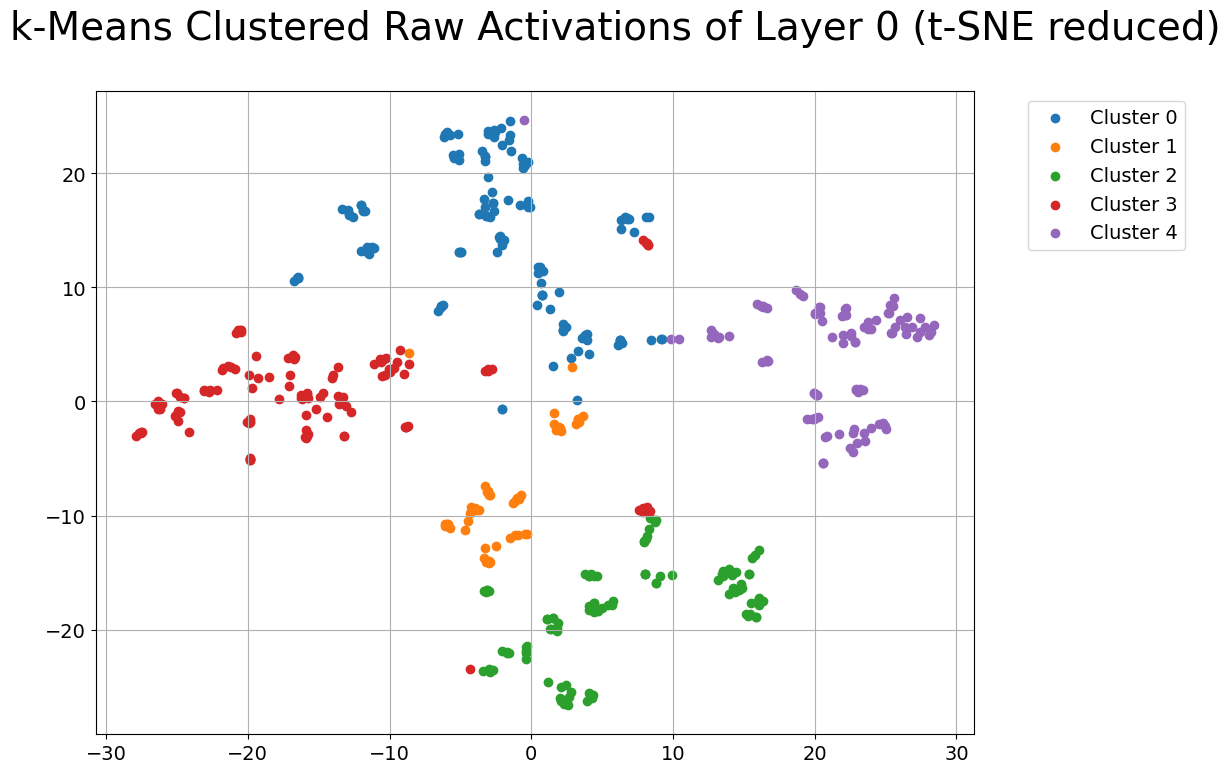

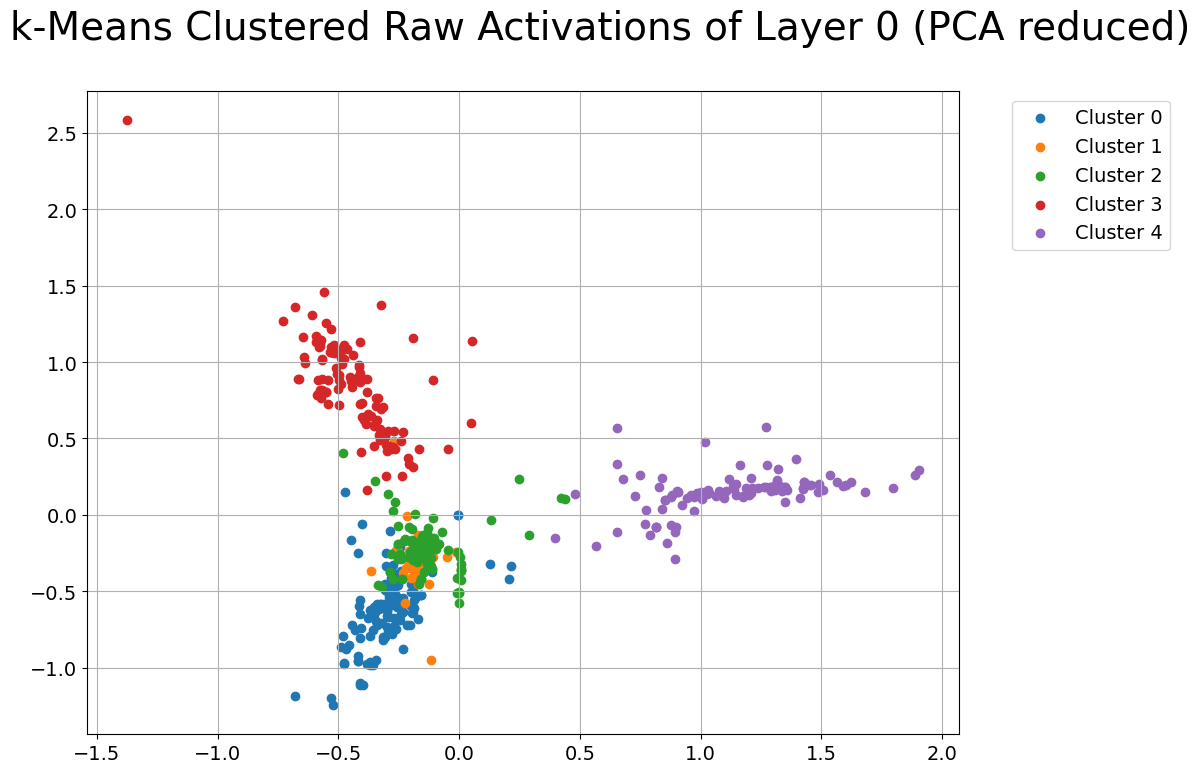

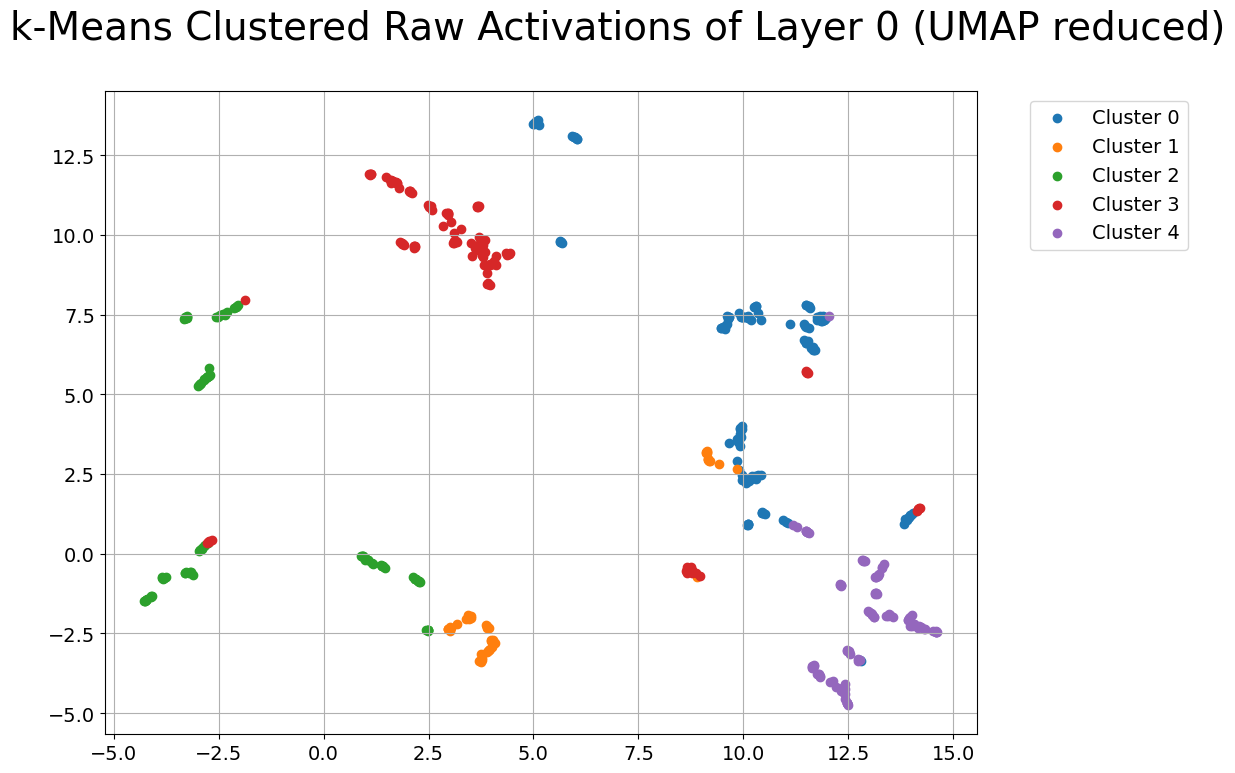

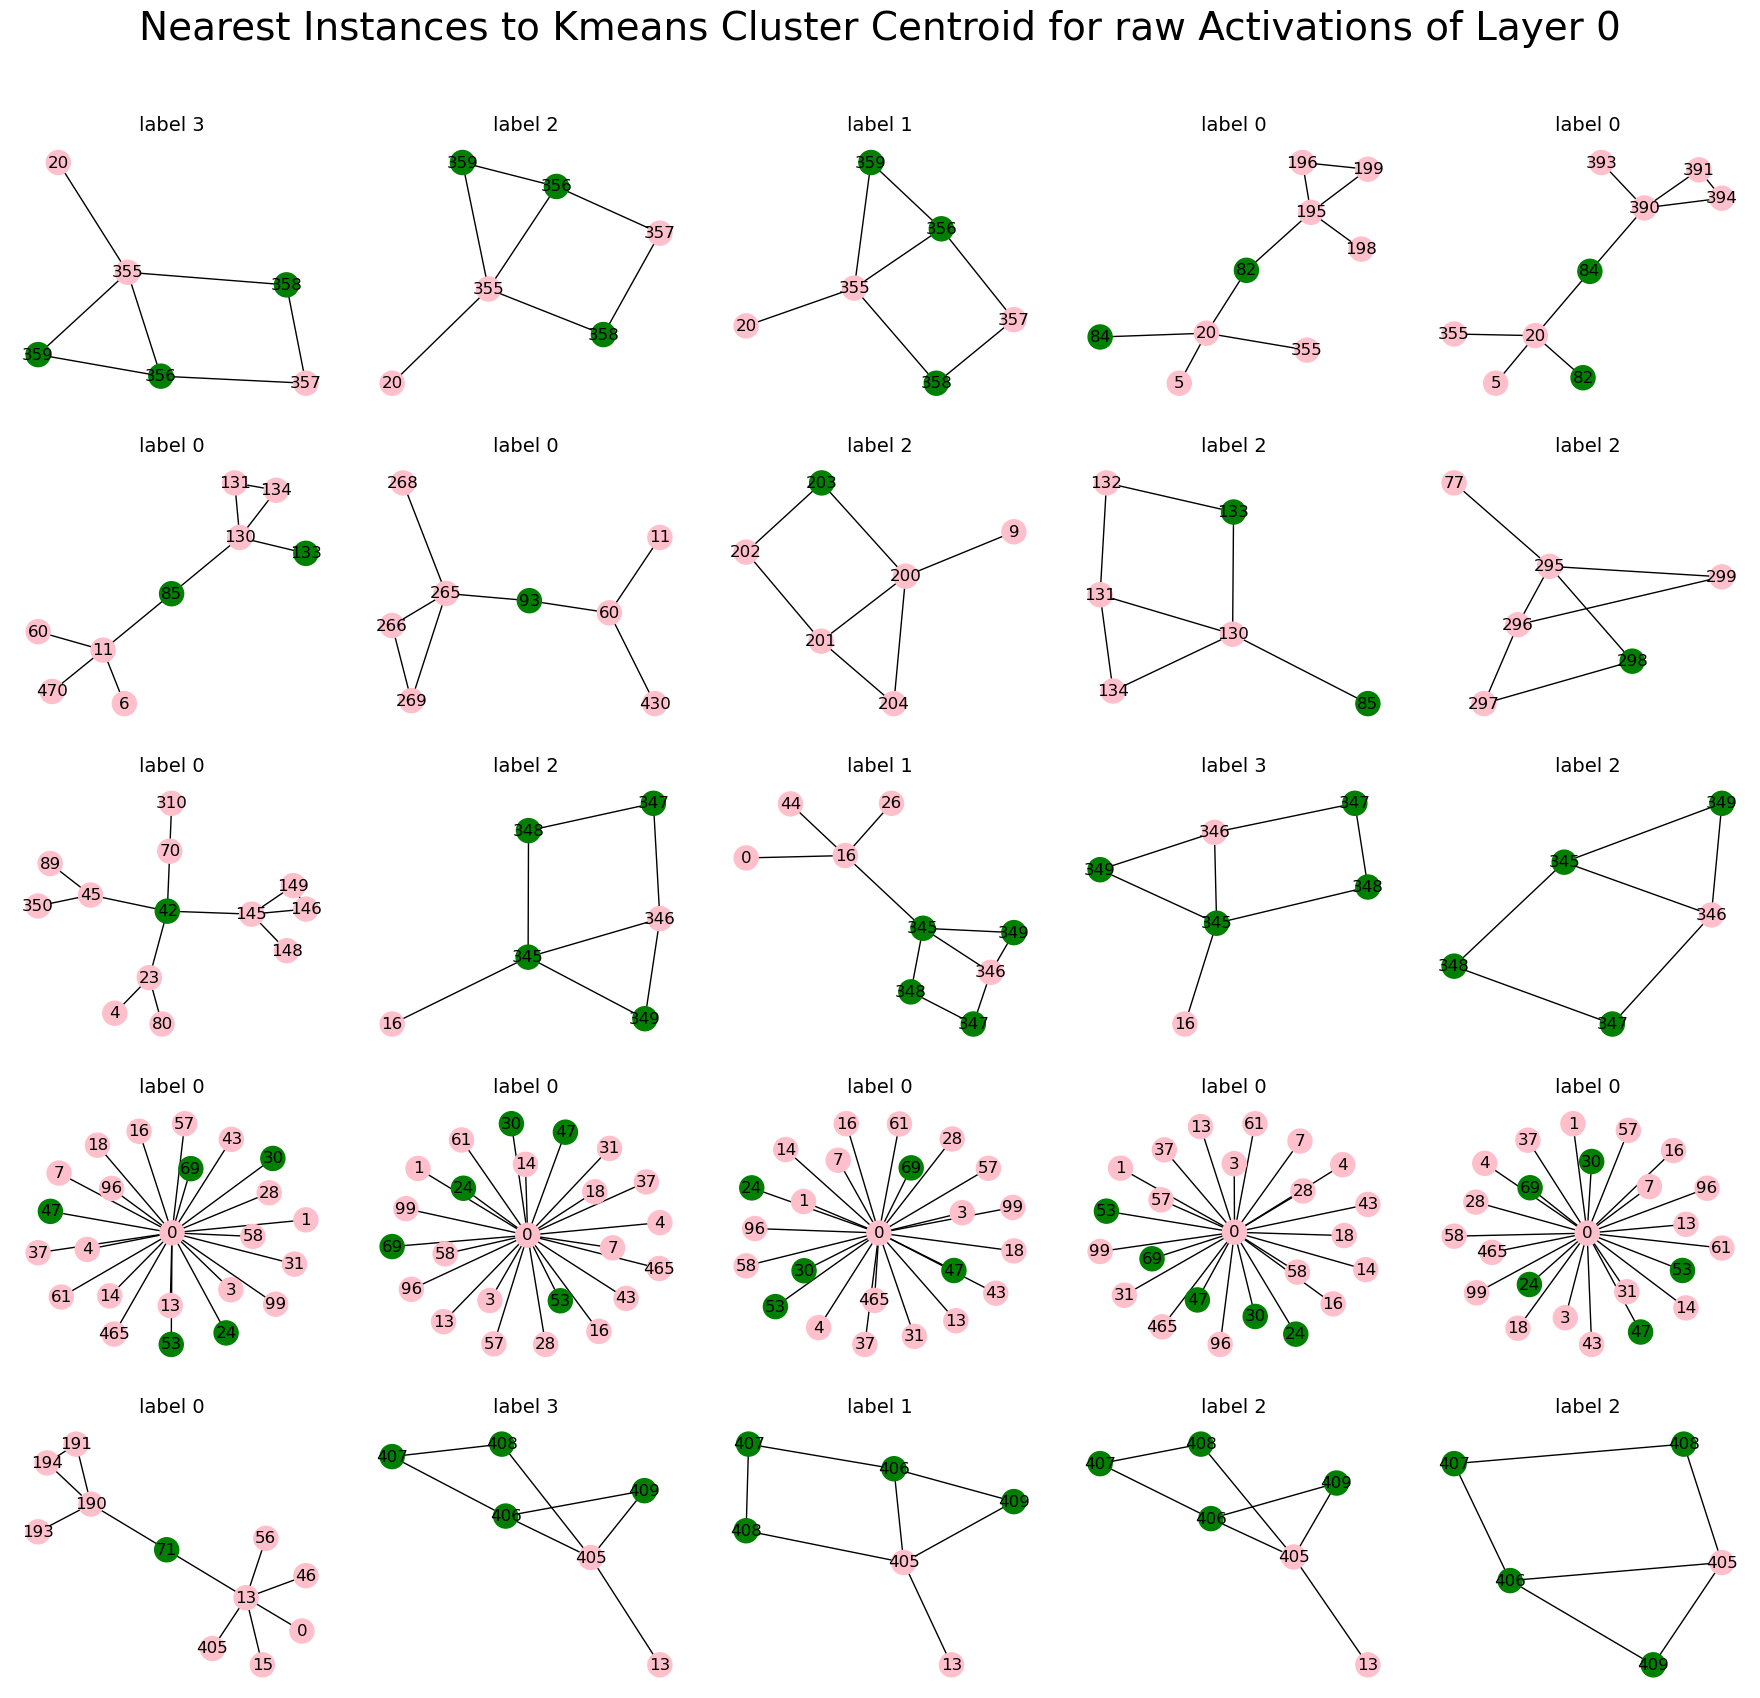

In [9]:
num_nodes_view = 5
num_expansions = 2
edges = data['edge_list'].numpy()

raw_kmeans_sample_feat = []
raw_kmeans_sample_graphs = []
raw_kmeans_models = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(activation)
    pred_labels = kmeans_model.predict(activation)
        
    plot_clusters(tsne_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_TSNE", "(t-SNE reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_PCA", "(PCA reduced)")
    plot_clusters(umap_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_UMAP", "(UMAP reduced)")
    sample_graphs, sample_feat = plot_samples(kmeans_model, activation, data["y"], layer_num, k, "Kmeans", "raw", num_nodes_view, edges, num_expansions, paths['KMeans'])

    raw_kmeans_sample_graphs.append(sample_graphs)
    raw_kmeans_sample_feat.append(sample_feat)
    raw_kmeans_models.append(kmeans_model)
    

##### TSNE

In [10]:
# tsne_kmeans_sample_graphs = []
# tsne_kmeans_sample_feat = []
# tsne_kmeans_models = []
# for layer_num, item in enumerate(tsne_data):
#     kmeans_model = KMeans(n_clusters=k, random_state=0)
#     kmeans_model = kmeans_model.fit(item)
#     pred_labels = kmeans_model.predict(item)

#     plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "t-SNE reduced")
#     sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

#     tsne_kmeans_sample_graphs.append(sample_graphs)
#     tsne_kmeans_sample_feat.append(sample_feat)
#     tsne_kmeans_models.append(kmeans_model)
    

##### PCA

In [11]:
# pca_kmeans_sample_graphs = []
# pca_kmeans_sample_feat = []
# pca_kmeans_models = []

# for layer_num, item in enumerate(pca_data):
#     kmeans_model = KMeans(n_clusters=k, random_state=0)
#     kmeans_model = kmeans_model.fit(item)
#     pred_labels = kmeans_model.predict(item)

#     plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "PCA reduced")
#     sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "PCA reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

#     pca_kmeans_sample_graphs.append(sample_graphs)
#     pca_kmeans_sample_feat.append(sample_feat)
#     pca_kmeans_models.append(kmeans_model)

##### UMAP

In [12]:
# umap_kmeans_sample_graphs = []
# umap_kmeans_sample_feat = []
# umap_kmeans_models = []
# for layer_num, item in enumerate(umap_data):
#     kmeans_model = KMeans(n_clusters=k, random_state=0)
#     kmeans_model = kmeans_model.fit(item)
#     pred_labels = kmeans_model.predict(item)

#     plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "UMAP reduced")
#     sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

#     umap_kmeans_sample_graphs.append(sample_graphs)
#     umap_kmeans_sample_feat.append(sample_feat)
#     umap_kmeans_models.append(kmeans_model)

#### Heuristics

In [13]:
# ba_heuristics = BA_Shapes_Heuristics()

# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "raw", paths['KMeans'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "t-SNE reduced", paths['KMeans'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "PCA reduced", paths['KMeans'])

# # for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "UMAP reduced", paths['KMeans'])


### Hierarchical Clustering

##### Raw

In [14]:
# for layer_num, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     plot_dendrogram(activation, "raw", layer_num, paths['Ward'])

In [15]:
# num_nodes_view = 5
# num_expansions = 2
# edges = data['edge_list'].numpy()

# raw_n_clusters = [4, 6, 23, 14, 30]

# raw_hc_sample_graphs = []
# raw_hc_sample_feat = []
# raw_hc_models = []
# for layer_num, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(activation)

#     d = (activation, pred_labels)
#     plot_clusters(tsne_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_TSNE", "(t-SNE reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_PCA", "(PCA reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_UMAP", "(UMAP reduced)")
#     sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "raw", num_nodes_view, edges, num_expansions, paths['Ward'])

#     raw_hc_sample_graphs.append(sample_graphs)
#     raw_hc_sample_feat.append(sample_feat)
#     raw_hc_models.append(hc)


##### TSNE

In [16]:
# for layer_num, item in enumerate(tsne_data):
#     plot_dendrogram(item, "t-SNE", layer_num, paths['Ward'])

In [17]:
# tsne_n_clusters = [5, 4, 30, 13, 7]

# tsne_hc_sample_graphs = []
# tsne_hc_sample_feat = []
# tsne_hc_models = []
# for layer_num, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(item)

#     d = (item, pred_labels)
#     plot_clusters(item, pred_labels, "HC", n, layer_num, paths['Ward'], "t-SNE")
#     sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['Ward'])

#     tsne_hc_sample_graphs.append(sample_graphs)
#     tsne_hc_sample_feat.append(sample_feat)
#     tsne_hc_models.append(hc)


##### PCA

In [18]:
# for layer_num, item in enumerate(pca_data):
#     plot_dendrogram(item, "PCA", layer_num, paths['Ward'])

In [19]:
# pca_n_clusters = [24, 7, 3, 5, 8]

# pca_hc_sample_graphs = []
# pca_hc_sample_feat = []
# pca_hc_models = []
# for layer_num, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(item)

#     d = (item, pred_labels)
#     plot_clusters(item, pred_labels, "HC", n, layer_num, paths['HC'], "PCA")
#     sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "PCA reduced", num_nodes_view, edges, num_expansions, paths['HC'])

#     pca_hc_sample_graphs.append(sample_graphs)
#     pca_hc_sample_feat.append(sample_feat)
#     pca_hc_models.append(hc)

##### UMAP

In [20]:
# for layer_num, item in enumerate(umap_data):
#     plot_dendrogram(item, "UMAP", layer_num, paths['Ward'])

In [21]:
# umap_n_clusters = [10, 24, 30, 30, 30]

# umap_hc_sample_graphs = []
# umap_hc_sample_feat = []
# umap_hc_models = []
# for layer_num, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(item)

#     d = (item, pred_labels)
#     plot_clusters(item, pred_labels, "HC", n, layer_num, paths['Ward'], "UMAP")
#     sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['Ward'])

#     umap_hc_sample_graphs.append(sample_graphs)
#     umap_hc_sample_feat.append(sample_feat)
#     umap_hc_models.append(hc)

#### Heuristics

In [22]:
# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "raw", paths['Ward'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "t-SNE reduced", paths['Ward'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "PCA reduced", paths['Ward'])

# for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "UMAP reduced", paths['Ward'])


### DBSCAN

##### Raw

In [23]:
# # num_nodes_view = 5
# # num_expansions = 2
# # edges = data['edge_list'].numpy()

# raw_dbscan_sample_feats = []
# raw_dbscan_sample_graphs = []
# raw_dbscan_models = []
# raw_dbscan_ds = []

# esp = 0.5
# min_samples = 5

# for layer_num, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(activation)
#     pred_labels = dbscan_model.fit_predict(activation)

#     num_cluster = len(np.unique(pred_labels))
#     d = (activation, pred_labels)
#     raw_dbscan_ds.append(d)

#     plot_clusters(tsne_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_TSNE", "(TSNE Reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_PCA", "(PCA Reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_UMAP", "(UMAP Reduced)")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "raw", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

#     raw_dbscan_sample_graphs.append(sample_graphs)
#     raw_dbscan_sample_feats.append(sample_feat)
#     raw_dbscan_models.append((dbscan_model, num_cluster))


##### TSNE

In [24]:
# tsne_dbscan_sample_graphs = []
# tsne_dbscan_sample_feats = []
# tsne_dbscan_models = []
# tsne_dbscan_ds = []

# for layer_num, item in enumerate(tsne_data):
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(item)
#     pred_labels = dbscan_model.fit_predict(item)

#     num_cluster = len(np.unique(pred_labels))
#     d = (item, pred_labels)
#     tsne_dbscan_ds.append(d)

#     plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "t-SNE")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

#     tsne_dbscan_sample_graphs.append(sample_graphs)
#     tsne_dbscan_sample_feats.append(sample_feat)
#     tsne_dbscan_models.append((dbscan_model, num_cluster))


##### PCA

In [25]:
# pca_dbscan_sample_graphs = []
# pca_dbscan_sample_feats = []
# pca_dbscan_models = []
# pca_dbscan_ds = []

# for layer_num, item in enumerate(pca_data):
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(item)
#     pred_labels = dbscan_model.fit_predict(item)

#     num_cluster = len(np.unique(pred_labels))
#     d = (item, pred_labels)
#     pca_dbscan_ds.append(d)

#     plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "PCA")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "PCA reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

#     pca_dbscan_sample_graphs.append(sample_graphs)
#     pca_dbscan_sample_feats.append(sample_feat)
#     pca_dbscan_models.append((dbscan_model, num_cluster))


##### UMAP

In [26]:
# umap_dbscan_sample_graphs = []
# umap_dbscan_sample_feats = []
# umap_dbscan_models = []
# umap_dbscan_ds = []

# for layer_num, item in enumerate(umap_data):
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(item)
#     pred_labels = dbscan_model.fit_predict(item)

#     num_cluster = len(np.unique(pred_labels))
#     d = (item, pred_labels)
#     umap_dbscan_ds.append(d)

#     plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "UMAP")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

#     umap_dbscan_sample_graphs.append(sample_graphs)
#     umap_dbscan_sample_feats.append(sample_feat)
#     umap_dbscan_models.append((dbscan_model, num_cluster))



#### Heuristics

In [27]:
# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "raw", paths['DBSCAN'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "t-SNE reduced", paths['DBSCAN'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "PCA reduced", paths['DBSCAN'])

# for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "UMAP reduced", paths['DBSCAN'])



# Activation to Concept to Class

### Using KMeans

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import tree, linear_model

import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestCentroid
import sklearn.metrics as metrics
import seaborn as sn

class ActivationClassifier():
    def __init__(self, pred_data, clustering_model, classifier_type, x, y, train_mask=None, test_mask=None, if_graph_class=False):
        self.pred_data = pred_data
        self.clustering_model = clustering_model
        self.classifier_type = classifier_type

        if if_graph_class:
            self.dataloader = x
            self.y = y
            self.train_mask = np.zeros(len(y))
            self.train_mask[:int(len(train_mask) * 0.8)] = 1
            self.test_mask = ~self.train_mask
        else:
            self.x = x.detach().numpy()
            self.y = y.detach().numpy()
            self.train_mask = train_mask
            self.test_mask = test_mask

        self.if_graph_class = if_graph_class

        if isinstance(self.clustering_model, AgglomerativeClustering) or isinstance(self.clustering_model, DBSCAN):
            self.y_hc = self.clustering_model.fit_predict(self.pred_data)

        self.classifier, self.accuracy = self._train_classifier()


    def _train_classifier(self):
        self.train_concepts = []
        self.test_concepts = []

        for node_idx in range(len(self.train_mask)):
            if self.train_mask[node_idx] == 1:
                self.train_concepts.append([self.activation_to_concept(node_idx)])
            else:
                self.test_concepts.append([self.activation_to_concept(node_idx)])

        if self.classifier_type == 'decision_tree':
            cls = tree.DecisionTreeClassifier()
            cls = cls.fit(self.train_concepts, self.y[self.train_mask])

        elif self.classifier_type == 'logistic_regression':
            cls = linear_model.LogisticRegression(multi_class='ovr', max_iter=1000, penalty='l1', solver='liblinear')
            cls = cls.fit(self.train_concepts, self.y[self.train_mask])

        # decision tree accuracy
        accuracy = cls.score(self.test_concepts, self.y[self.test_mask])

        return cls, accuracy


    def get_classifier_accuracy(self):
        return self.accuracy


    def _activation_to_cluster(self, node):
        # apply tsne
        if isinstance(self.clustering_model, KMeans):
            cluster = self.clustering_model.predict(self.pred_data)
            cluster = cluster[node]

        elif isinstance(self.clustering_model, AgglomerativeClustering) or isinstance(self.clustering_model, DBSCAN):
            cluster = np.array(self.y_hc[node])

        return cluster


    def _cluster_to_concept(self, cluster):
        concept = cluster

        return concept


    def activation_to_concept(self, node):
        # get cluster for node
        cluster = self._activation_to_cluster(node)

        # return cluster number as substitute of concept
        concept = self._cluster_to_concept(cluster)

        return concept


    def concept_to_class(self, concept):
        concept = concept.reshape(1, -1)
        pred = self.classifier.predict(concept)

        return pred


    def plot(self, path, layer_num, k, reduction_type):
        if self.classifier_type == 'decision_tree':
            fig, ax = plt.subplots(figsize=(20, 20))
            tree.plot_tree(self.classifier, ax=ax)
            fig.suptitle(f"Decision Tree for {reduction_type} Model")

        elif self.classifier_type == 'logistic_regression':
            fig, ax = plt.subplots(figsize=(6, 6))
            pred = self.classifier.predict(self.test_concepts)
            ls = np.unique(self.y)
            confusion_matrix = metrics.confusion_matrix(self.y[self.test_mask], pred, labels=ls)
            cm = pd.DataFrame(confusion_matrix, index=ls, columns=ls)

            ax = sn.heatmap(cm, annot=True, cmap="YlGnBu", ax=ax, fmt='g', )
            fig.suptitle(f"Confusion Matrix of Logistic Regression on for {reduction_type} Model")
            ax.set_xlabel("Target Class")
            ax.set_ylabel("Predicted Class")

        plt.savefig(os.path.join(path, f"{k}k_{layer_num}layer_{reduction_type}_{self.classifier_type}.png"))
        plt.show()


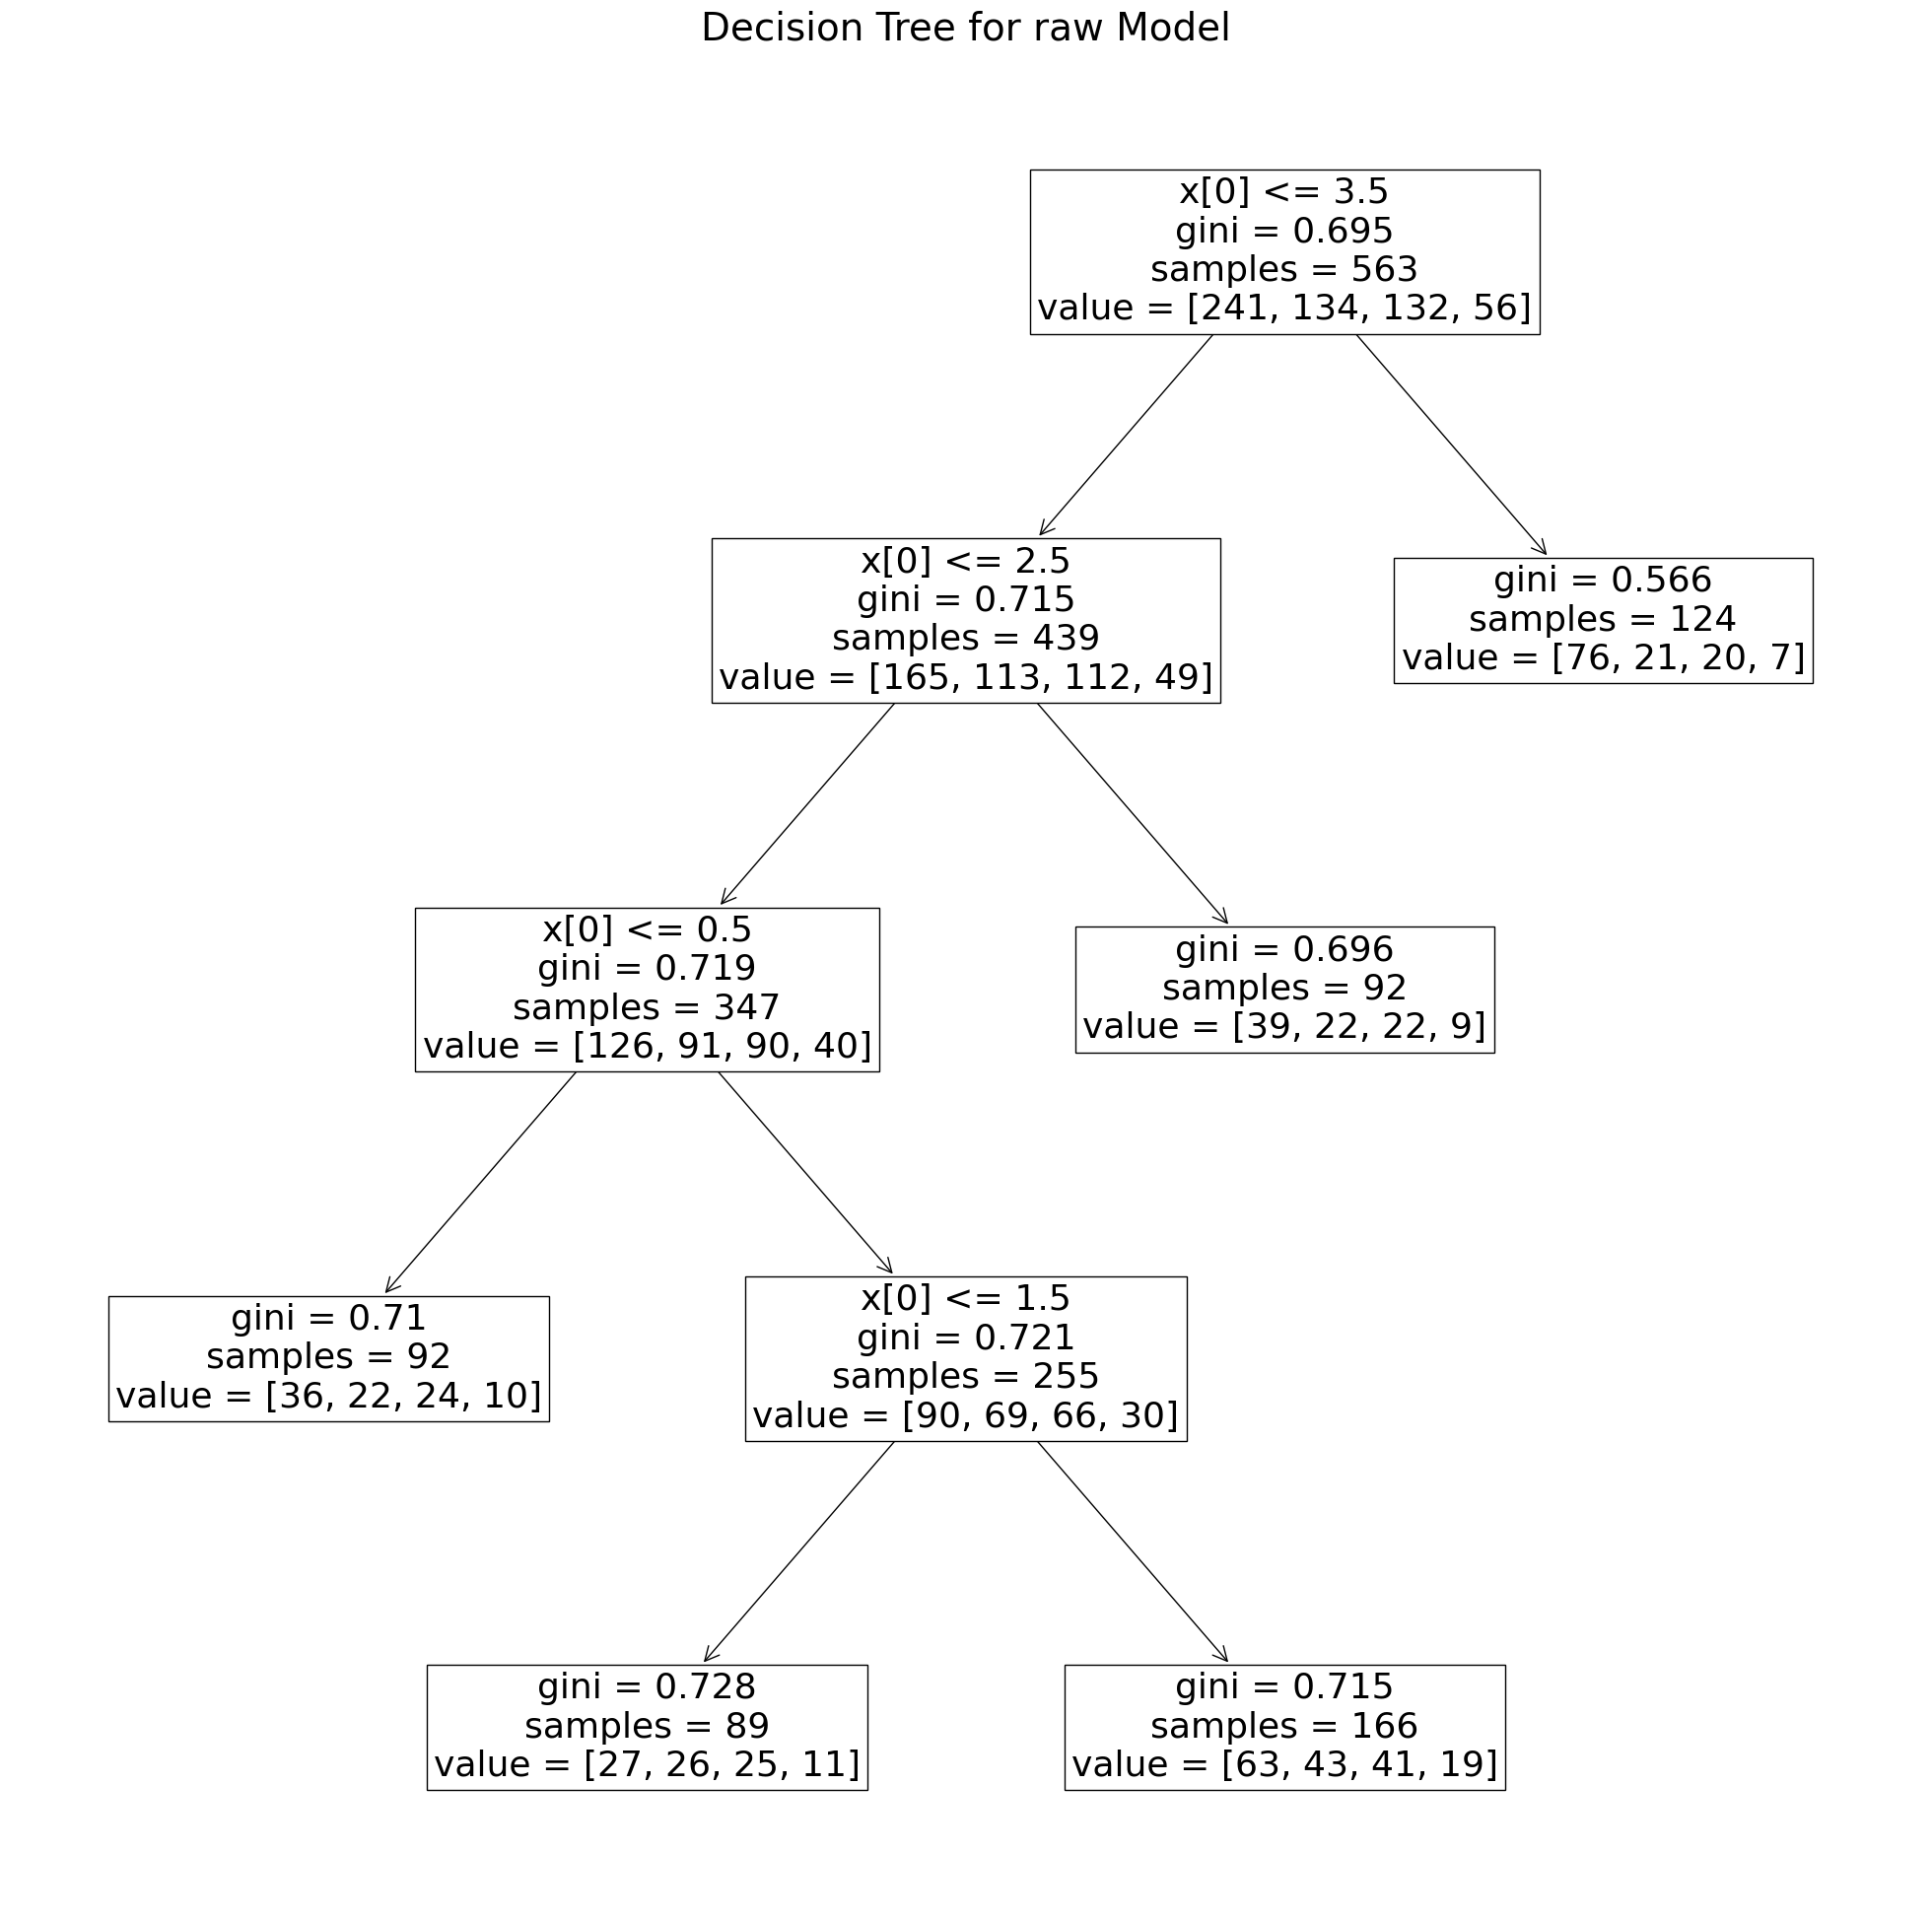

0   0.4306569343065693


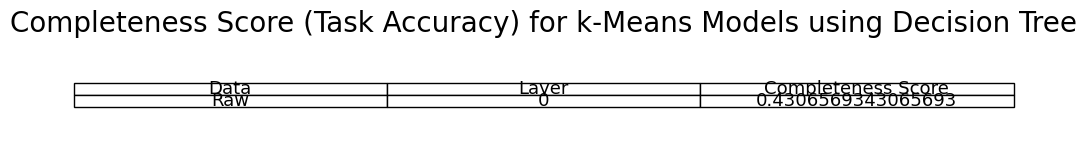

In [29]:
classifier_str = "decision_tree"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     x = activation_cls.test_concepts
#     y = np.array(data['y'][data['test_mask']]).astype(int)
#     colors = []
#     for y1 in y:
#         color = 'blue'
        
#         if y1 == 1:
#             color = 'red'
#         if y1 == 2:
#             color = 'green'
#         if y1 == 3:
#             color = 'orange'
        
#         colors.append(color)
        
#     print(colors)
    
#     fig, ax = plt.subplots()
#     ax.scatter(x, y, c=colors)
#     fig.suptitle("Concept Label plotted against the Node Classification Label \n for BA-Shapes")
#     ax.set_ylim(0, 3)
#     ax.set_xlim(0, 9)
# #     plt.yticks(list(range(0, 4)))
#     plt.show()
    
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "raw")
    print(i, " ", activation_cls.get_classifier_accuracy())
    
# for i, item in enumerate(tsne_data):
#     activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])

#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "t-SNE")

# for i, item in enumerate(pca_data):
#     activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])

#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "PCA")

# for i, item in enumerate(umap_data):
#     activation_cls = ActivationClassifier(item, umap_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])

#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "UMAP")

plot_completeness_table("k-Means", "Decision Tree", completeness_scores, paths['KMeans'])

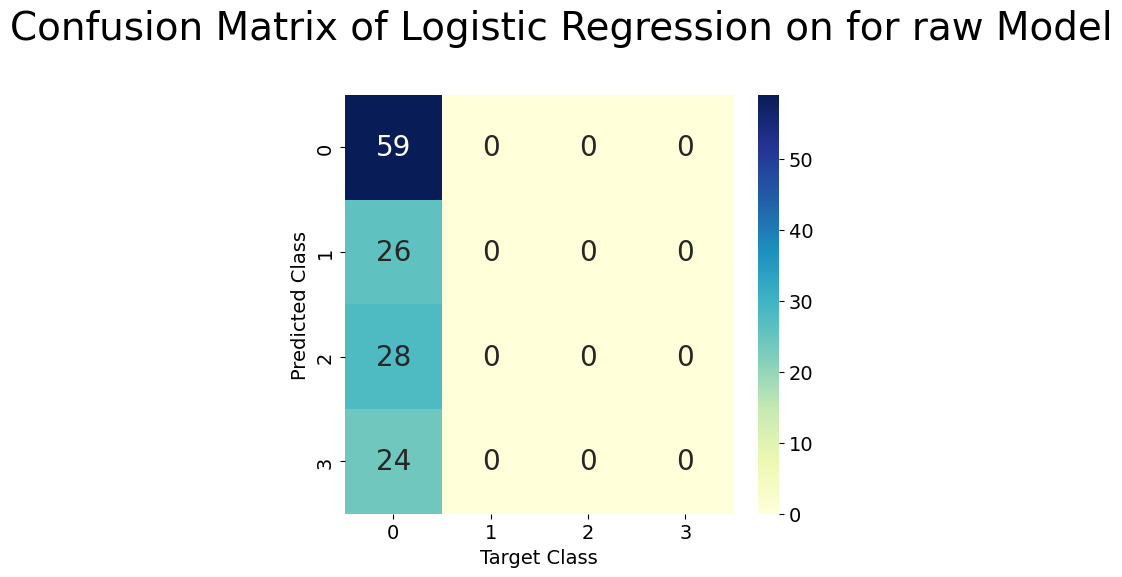

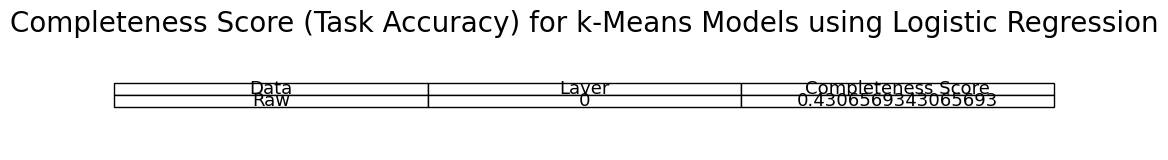

In [30]:
classifier_str = "logistic_regression"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "raw")
    
# for i, item in enumerate(tsne_data):
#     activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "t-SNE")
    
# for i, item in enumerate(pca_data):
#     activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "PCA")
    
# for i, item in enumerate(umap_data):
#     activation_cls = ActivationClassifier(item, umap_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "UMAP")
    
plot_completeness_table("k-Means", "Logistic Regression", completeness_scores, paths['KMeans'])
    

### Using Hierarchical Clustering

##### Using Ward

In [31]:
# classifier_str = "decision_tree"

# completeness_scores = []

# for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "raw")
    
# for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
#     activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "t-SNE")
    
# for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
#     activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "PCA")
    
# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     activation_cls = ActivationClassifier(item, umap_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "UMAP")

# plot_completeness_table("HC", "Decision Tree", completeness_scores, paths["Ward"])



In [32]:
# classifier_str = "logistic_regression"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "raw")
    
# for i, item in enumerate(tsne_data):
#     activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "t-SNE")
    
# for i, item in enumerate(pca_data):
#     activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "PCA")
    
# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     activation_cls = ActivationClassifier(item, umap_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "UMAP")

# plot_completeness_table("HC", "Logistic Regression", completeness_scores, paths["Ward"])
    

##### Using DBSCAN

In [33]:
# classifier_str = "decision_tree"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
    
#     dbscan_model, n = raw_dbscan_models[i]
#     activation_cls = ActivationClassifier(activation, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "raw")
    
# for i, item in enumerate(tsne_data):
#     dbscan_model, n = tsne_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "t-SNE")
    
# for i, item in enumerate(pca_data):
#     dbscan_model, n = pca_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "PCA")
    
# for i, item in enumerate(umap_data):
#     dbscan_model, n = umap_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "UMAP")

# plot_completeness_table("DBSCAN", "Decision Tree", completeness_scores, paths["DBSCAN"])


In [34]:
# classifier_str = "logistic_regression"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     dbscan_model, n = raw_dbscan_models[i]
#     activation_cls = ActivationClassifier(activation, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "raw")
    
# for i, item in enumerate(tsne_data):
#     dbscan_model, n = tsne_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "t-SNE")
    
# for i, item in enumerate(pca_data):
#     dbscan_model, n = pca_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "PCA")
    
# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     dbscan_model, n = umap_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "UMAP")

# plot_completeness_table("DBSCAN", "Logistic Regression", completeness_scores, paths["DBSCAN"])
    

# Graph Similarity

In [35]:
##### KMeans

Nodes  2  Graphs  3
0
Nodes  3  Graphs  3
0.5
Nodes  2  Graphs  3
0
Nodes  2  Graphs  3
0
Nodes  2  Graphs  3
0


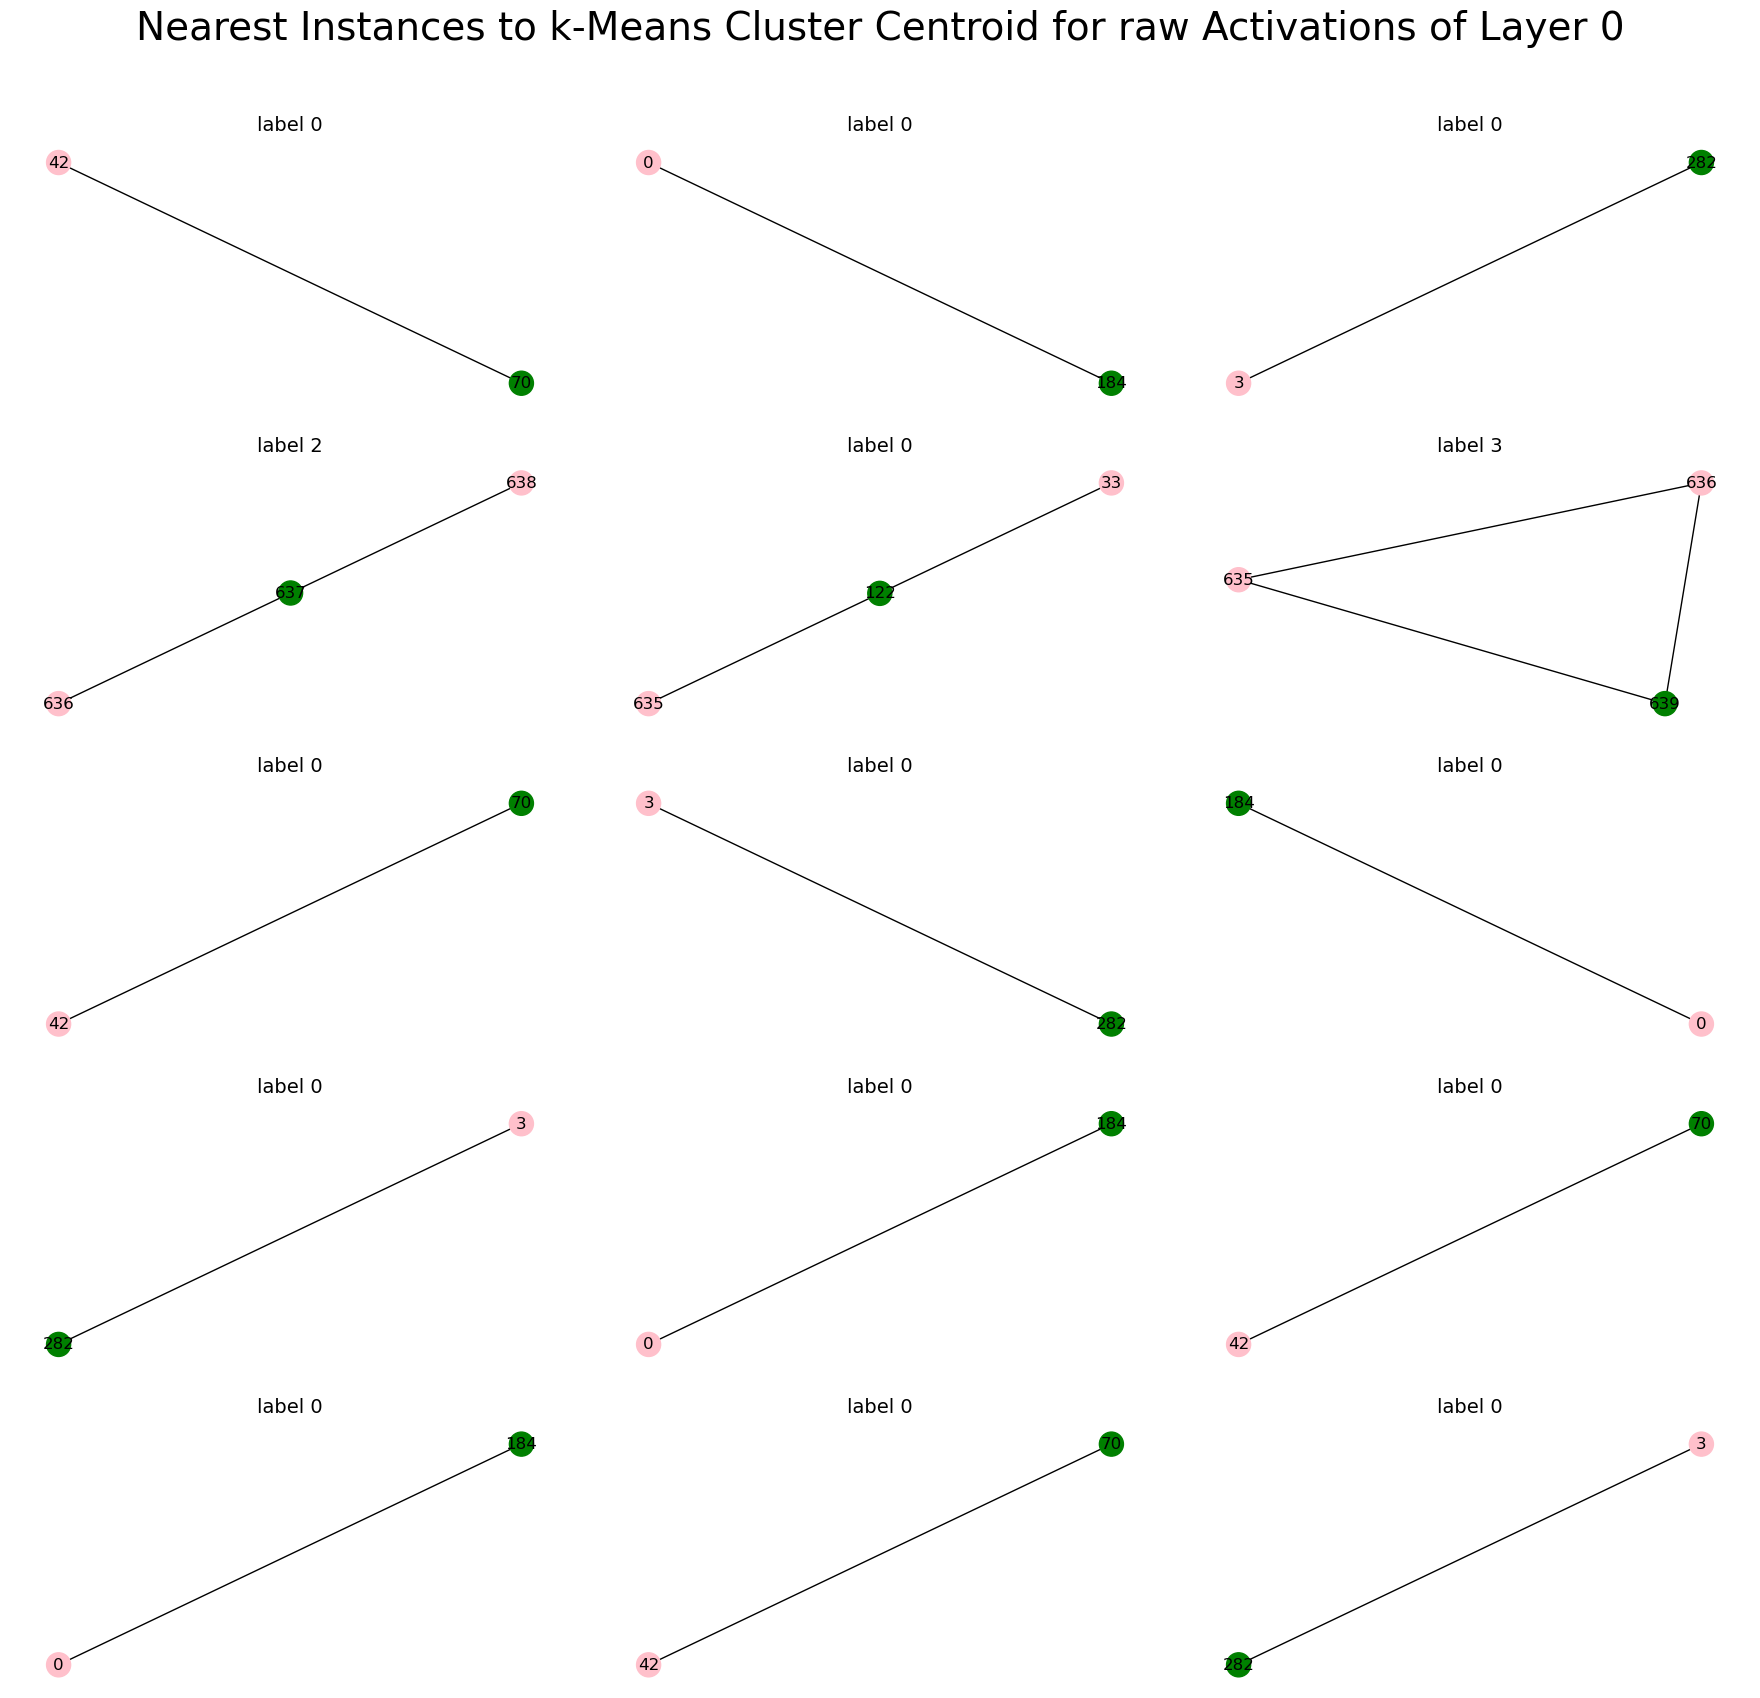

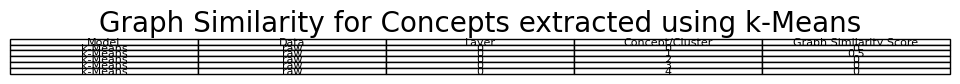

In [36]:
graph_scores = []
view = 3
max_num_nodes = 15

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    distances = get_node_distances(raw_kmeans_models[i], activation)

    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["k-Means", "raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(raw_kmeans_models[i], activation, data['y'], i, k, "k-Means", "raw", view, edges, num_expansions, paths['KMeans'])
        
        
# for i, item in enumerate(tsne_data):    
#     distances = get_node_distances(tsne_kmeans_models[i], item)
    
#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)

#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["k-Means", "t-SNE", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(tsne_kmeans_models[i], item, data['y'], i, k, "k-Means", "t-SNE", view, edges, num_expansions, paths['KMeans'])
    
# for i, item in enumerate(pca_data):
#     distances = get_node_distances(pca_kmeans_models[i], item)
    
#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["k-Means", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(pca_kmeans_models[i], item, data['y'], i, k, "k-Means", "PCA", view, edges, num_expansions, paths['KMeans'])


# for i, item in enumerate(umap_data):
#     distances = get_node_distances(umap_kmeans_models[i], item)
    
#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["k-Means", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(umap_kmeans_models[i], item, data['y'], i, k, "k-Means", "UMAP", view, edges, num_expansions, paths['KMeans'])
    
plot_graph_similarity_table("k-Means", graph_scores, paths['KMeans'])
    

In [37]:
# graph_scores = []
# view = 3
# max_num_nodes = 15

# graph_scores = []

# for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     pred_labels = raw_hc_models[i].fit_predict(activation)
#     d_item = (activation, pred_labels)
#     distances = get_node_distances(raw_hc_models[i], d_item)
    
#     for k_idx in range(n):        
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
                
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["HC", "raw", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(raw_hc_models[i], d_item, data["y"], i, n, "HC", "raw", view, edges, num_expansions, paths['Ward'])
        
        
# for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)): 
#     pred_labels = tsne_hc_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(tsne_hc_models[i], d_item)
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["HC", "t-SNE", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(tsne_hc_models[i], d_item, data["y"], i, n, "HC", "t-SNE", view, edges, num_expansions, paths['Ward'])
        

        
# for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
#     pred_labels = pca_hc_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(pca_hc_models[i], d_item)

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["HC", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(pca_hc_models[i], d_item, data["y"], i, n, "HC", "PCA", view, edges, num_expansions, paths['Ward'])
    

# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     pred_labels = umap_hc_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(umap_hc_models[i], d_item)

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["HC", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(umap_hc_models[i], d_item, data["y"], i, n, "HC", "UMAP", view, edges, num_expansions, paths['Ward'])
        
    
# plot_graph_similarity_table("HC", graph_scores, paths['Ward'])
    

In [38]:
# graph_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
    
#     dbscan_model, n = raw_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, raw_dbscan_ds[i])

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "raw", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, raw_dbscan_ds[i], data['y'], i, n, "DBSCAN", "raw", view, edges, num_expansions, paths['DBSCAN'])
        
# for i, item in enumerate(tsne_data):  
#     dbscan_model, n = tsne_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, tsne_dbscan_ds[i])
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)

#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "t-SNE", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, tsne_dbscan_ds[i], data['y'], i, n, "DBSCAN", "t-SNE", view, edges, num_expansions, paths['DBSCAN'])
    
# for i, item in enumerate(pca_data):
#     dbscan_model, n = pca_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, pca_dbscan_ds[i])
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, pca_dbscan_ds[i], data['y'], i, n, "DBSCAN", "PCA", view, edges, num_expansions, paths['DBSCAN'])


# for i, item in enumerate(umap_data):
#     dbscan_model, n = umap_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, umap_dbscan_ds[i])
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, umap_dbscan_ds[i], data['y'], i, n, "DBSCAN", "UMAP", view, edges, num_expansions, paths['DBSCAN'])
    
# plot_graph_similarity_table("DBSCAN", graph_scores, paths['DBSCAN'])
    

# GNNExplainer

In [39]:
node_idx = 514

In [42]:
activation_list

{'embs': tensor([[-1.4463, -0.3581,  1.2324,  ...,  1.9447, -1.0346,  0.2333],
         [-0.3713,  0.2002, -0.6037,  ...,  1.2494, -0.5283, -0.1595],
         [-0.2285,  0.5573, -0.4148,  ...,  0.3161, -0.1839,  0.4148],
         ...,
         [-0.2878,  0.0360, -0.0819,  ..., -0.6085, -0.5696,  0.1320],
         [-0.2591,  0.0285, -0.1072,  ..., -0.5971, -0.5871,  0.1386],
         [-0.2472,  0.0353, -0.0855,  ..., -0.5944, -0.5723,  0.1429]])}

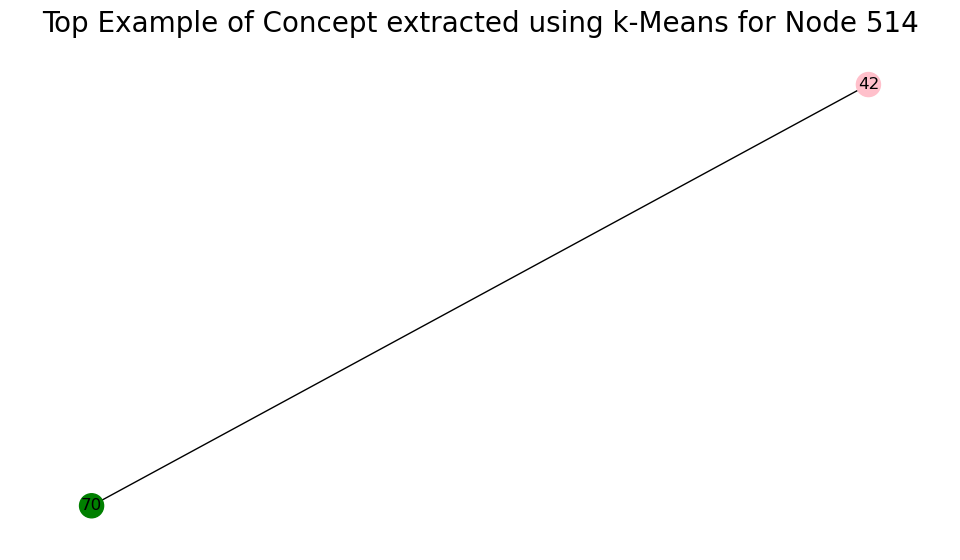

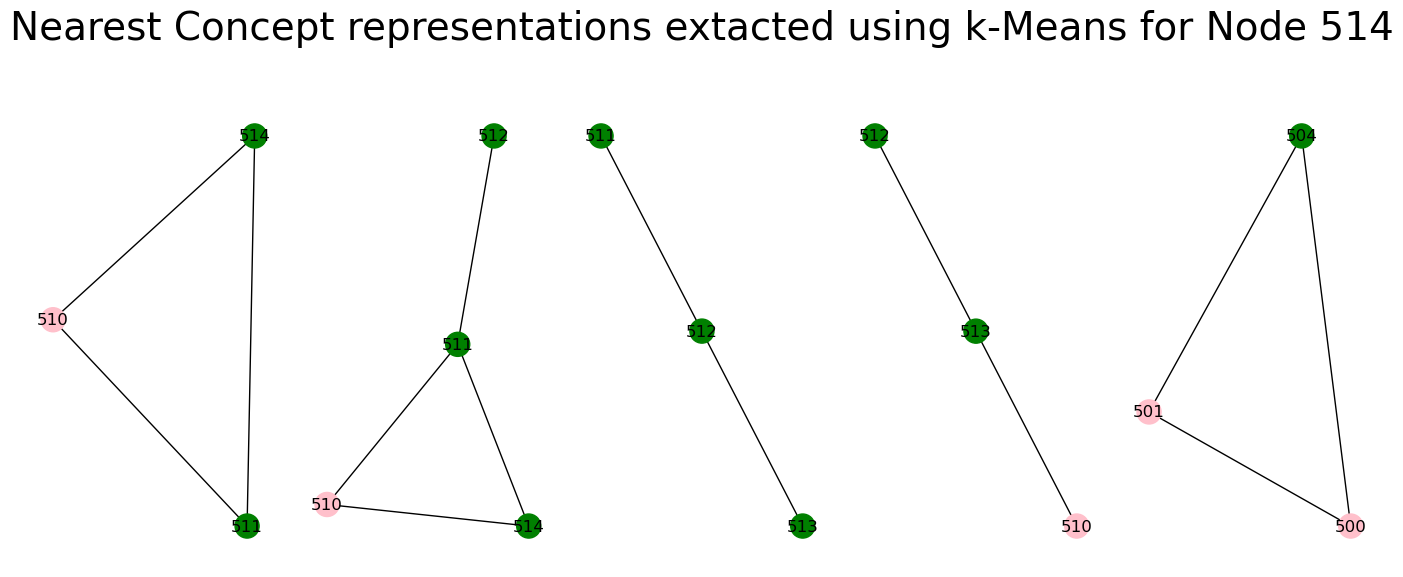

In [43]:
# Explain using k-Means
edges = data['edge_list'].numpy()

# get predicted cluster label - visualise top representations in cluster
# activation_key = 'conv3'
activation_key = 'embs'
layer_idx = 0

# get concept number
activations = torch.squeeze(activation_list[activation_key]).detach().numpy()
concepts = raw_kmeans_models[layer_idx].predict(activations) 

# get top example for concept/cluster
concept = concepts[node_idx]
top_graph = raw_kmeans_sample_graphs[layer_idx][concept][0]
color_map = raw_kmeans_sample_feat[layer_idx][concept]

fig, ax = plt.subplots()
nx.draw(top_graph, node_color=color_map, with_labels=True, ax=ax)
ax.set_title(f"Top Example of Concept extracted using k-Means for Node {node_idx}")
plt.show()

# get closest concept representations to what trying to explain
indices_in_cluster = np.argwhere(concepts == concept).flatten()
clustered_activations = activations[indices_in_cluster]

from sklearn.neighbors import NearestNeighbors
nearest_neighbours = NearestNeighbors(n_neighbors=5).fit(clustered_activations)
neighbours = nearest_neighbours.kneighbors(np.expand_dims(activations[node_idx], axis=0), 5)

neighbours = indices_in_cluster[neighbours[1]].flatten()
tg, cm, labels, _ = get_top_subgraphs(neighbours, data['y'], edges, num_expansions)

fig, axs = plt.subplots(1, len(neighbours), figsize=(14, 6))
fig.suptitle(f"Nearest Concept representations extacted using k-Means for Node {node_idx}")
for i, (g, c, l) in enumerate(zip(tg, cm, labels)):
    nx.draw(g, node_color=c, with_labels=True, ax=axs[i])
    ax.set_title(f"label {l}", fontsize=14)

In [ ]:
# # node_idx = 698

# # get predicted cluster label - visualise top representations in cluster
# activation_layer = 'conv3'
# layer_idx = 3
# n = 14

# # get top surrouning examples
# activations = torch.squeeze(activation_list[activation_key]).detach().numpy()
# hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
# concepts = hc.fit_predict(activations)

# d = (activations, concepts)

# concept = concepts[node_idx]

# def get_top_example(clustering_model, data, y, edges, cluster_num, num_expansions):
#     res_sorted = get_node_distances(clustering_model, data)
    
#     if isinstance(clustering_model, AgglomerativeClustering) or isinstance(clustering_model, DBSCAN):
#         print(res_sorted.shape)
#         distances = res_sorted[cluster_num]
#     elif isinstance(clustering_model, KMeans):
#         distances = res_sorted[:, cluster_num]
            
#     top_index = np.argsort(distances)[::][0]
#     tg, cm, labels, _ = get_top_subgraphs([top_index], y, edges, num_expansions)

#     fig, ax = plt.subplots()
#     fig.suptitle(f"Top Example of Concept extracted using HC for Node {node_idx}")
    
#     nx.draw(tg[0], node_color=cm[0], with_labels=True, ax=ax)
#     ax.set_title(f"label {labels[0]}", fontsize=14)

    
# edges = data['edge_list'].numpy()
# # get top example for concept/cluster
# get_top_example(hc, d, data['y'], edges, concept, num_expansions)

# # get closest concept representations to what trying to explain
# indices_in_cluster = np.argwhere(concepts == concept).flatten()
# clustered_activations = activations[indices_in_cluster]

# from sklearn.neighbors import NearestNeighbors
# nearest_neighbours = NearestNeighbors(n_neighbors=5).fit(clustered_activations)
# neighbours = nearest_neighbours.kneighbors(np.expand_dims(activations[node_idx], axis=0), 5)

# neighbours = indices_in_cluster[neighbours[1]].flatten()
# tg, cm, labels, _ = get_top_subgraphs(neighbours, data['y'], edges, num_expansions)

# fig, axs = plt.subplots(1, len(neighbours), figsize=(14, 6))
# fig.suptitle(f"Nearest Concept representations extacted using HC for Node {node_idx}")
# for i, (g, c, l) in enumerate(zip(tg, cm, labels)):
#     nx.draw(g, node_color=c, with_labels=True, ax=axs[i])
#     ax.set_title(f"label {l}", fontsize=14)

In [ ]:
# # node_idx = 698

# # Explain using DBSCAN
# eps = 0.1
# min_samples = 3

# # get predicted cluster label - visualise top representations in cluster
# activation_layer = 2
# layer_idx = 3

# # get top surrouning examples
# activations = umap_data[activation_layer]
# dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
# concepts = dbscan_model.fit_predict(activations)

# num_cluster = len(np.unique(concepts))
# print("Num clusters: ", num_cluster)
# d = (activations, concepts)

# concept = concepts[node_idx]

# def get_top_example(clustering_model, data, y, edges, cluster_num, num_expansions):
#     res_sorted = get_node_distances(clustering_model, data)
    
#     if isinstance(clustering_model, AgglomerativeClustering) or isinstance(clustering_model, DBSCAN):
#         print(res_sorted.shape)
#         distances = res_sorted[cluster_num]
#     elif isinstance(clustering_model, KMeans):
#         distances = res_sorted[:, cluster_num]
            
#     top_index = np.argsort(distances)[::][0]
#     tg, cm, labels = get_top_subgraphs([top_index], y, edges, num_expansions)

#     fig, ax = plt.subplots()
#     fig.suptitle("Top Example of Concept extracted using DBSCAN for Node 462")
    
#     nx.draw(tg[0], node_color=cm[0], with_labels=True, ax=ax)
#     ax.set_title(f"label {labels[0]}", fontsize=14)

    
# edges = data['edge_list'].numpy()
# # get top example for concept/cluster
# get_top_example(dbscan_model, d, data['y'], edges, concept, 1)

# # get closest concept representations to what trying to explain
# indices_in_cluster = np.argwhere(concepts == concept).flatten()
# clustered_activations = activations[indices_in_cluster]

# from sklearn.neighbors import NearestNeighbors
# nearest_neighbours = NearestNeighbors(n_neighbors=5).fit(clustered_activations)
# neighbours = nearest_neighbours.kneighbors(np.expand_dims(activations[node_idx], axis=0), 5)

# neighbours = indices_in_cluster[neighbours[1]].flatten()
# tg, cm, labels = get_top_subgraphs(neighbours, data['y'], edges, num_expansions)

# fig, axs = plt.subplots(1, len(neighbours), figsize=(14, 6))
# fig.suptitle("Nearest Concept representations extacted using DBSCAN for Node 462")
# for i, (g, c, l) in enumerate(zip(tg, cm, labels)):
#     nx.draw(g, node_color=c, with_labels=True, ax=axs[i])
#     ax.set_title(f"label {label}", fontsize=14)

In [ ]:
# # convert to edge format
# edges = data['edges'].t().contiguous()

# explainer = GNNExplainer(model, epochs=1000, return_type='log_prob', log=True)
# node_feat_mask, edge_mask = explainer.explain_node(node_idx, data['x'], data['edges'])


In [ ]:

# ax, G = explainer.visualize_subgraph(node_idx, data['edges'], edge_mask, y=data['y'], threshold=0.8)
# plt.title(f"GNNExplainer explanation for Node {node_idx}")
# plt.axis('off')
# plt.show()